In [1]:
from keras.models import Model
from keras.layers import Input, LSTM
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
now = datetime.datetime.now

batch_size = 10

# length of data sequences
n_timesteps = 100
# dimension of data sequences
n_dim = 88

In [2]:
import csv
import numpy as np

f = open('Data_KIMORE_e5/Train_X.csv')
csv_f = csv.reader(f)
Train_X = list(csv_f)

# Convert the input sequences into numpy arrays
train_input1 = np.asarray(Train_X, dtype = float)
n_dim = 88
x = np.zeros((204,100,n_dim))
for i in range(len(train_input1)//100):
      x[i,:,:] = train_input1[100*i:100*(i+1),:]

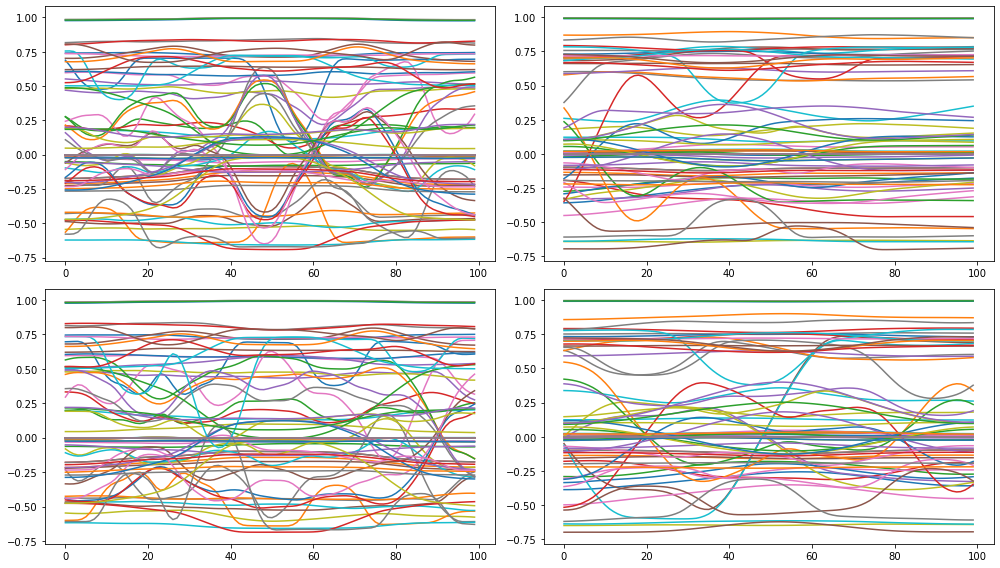

In [3]:
plt.figure(figsize = (14,8))
plt.subplot(2,2,1)
plt.plot(x[0])
plt.subplot(2,2,2)
plt.plot(x[-1])
plt.subplot(2,2,3)
plt.plot(x[1])
plt.subplot(2,2,4)
plt.plot(x[-2])
plt.tight_layout()
plt.show()

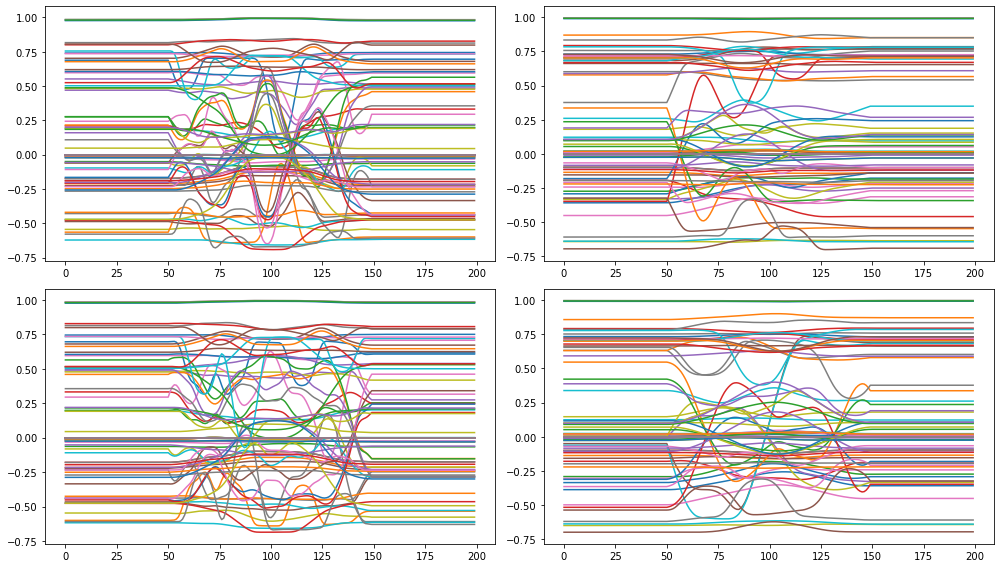

In [4]:
# Add 50 time frames at the beginning and end of sequences
# The autoencoder has difficulties with the beginning and ending frames
data = np.zeros((x.shape[0],n_timesteps+100,n_dim))
for i in range(x.shape[0]):
    data[i,:,:] = np.concatenate((np.concatenate((np.tile(x[i,0,:],[50, 1]), x[i,:,:])), np.tile(x[i,-1,:],[50, 1])))
    
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (14,8))
plt.subplot(2,2,1)
plt.plot(data[0])
plt.subplot(2,2,2)
plt.plot(data[-1])
plt.subplot(2,2,3)
plt.plot(data[1])
plt.subplot(2,2,4)
plt.plot(data[-2])
plt.tight_layout()
plt.show()

In [5]:
# Encoder layers
input_seq = Input(shape=(n_timesteps+100,n_dim))
encoded1 = LSTM(30,return_sequences = True)(input_seq)
encoded2 = LSTM(10,return_sequences = True)(encoded1)
# Encoded representation of the input, 340x4 vector
encoded = LSTM(4,return_sequences = True)(encoded2)
# Decoder layers
decoded1 = LSTM(10,return_sequences = True)(encoded)
decoded2 = LSTM(30,return_sequences = True)(decoded1)
decoded = LSTM(n_dim, return_sequences = True)(decoded2)

# The model maps an input to its reconstruction
autoencoder = Model(inputs=input_seq, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 88)]         0         
                                                                 
 lstm (LSTM)                 (None, 200, 30)           14280     
                                                                 
 lstm_1 (LSTM)               (None, 200, 10)           1640      
                                                                 
 lstm_2 (LSTM)               (None, 200, 4)            240       
                                                                 
 lstm_3 (LSTM)               (None, 200, 10)           600       
                                                                 
 lstm_4 (LSTM)               (None, 200, 30)           4920      
                                                                 
 lstm_5 (LSTM)               (None, 200, 88)           41888 

In [6]:
# Shuffle the sequences to create a training and validation sets
import random
trainidx = random.sample(range(0,data.shape[0]),63)
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
train_data = data[trainidx,:,:]
valid_data = data[valididx,:,:]

In [7]:
np.shape(train_data)

(63, 200, 88)

In [8]:
# Train an autoencoder on the correct data sequences

# Measure the training time 
t = now()

# Request to stop before reaching the number of epochs if the validation loss does not decrease for 1000 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 1000)

history = autoencoder.fit(train_data, train_data, epochs = 10000, batch_size = batch_size, shuffle=True,
                validation_data=(valid_data, valid_data), verbose = 0, callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Training time: 4:21:17.806619


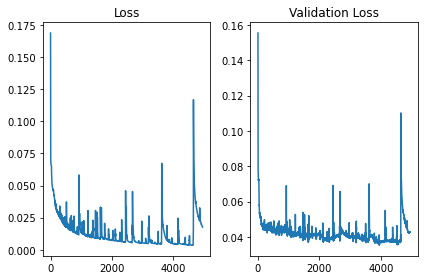

0.0177060067653656
0.04290464520454407


In [9]:
# Plot the training and validation results
plt.figure(1)
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.tight_layout()
plt.show()

# Print the resulting training and validation loss values
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

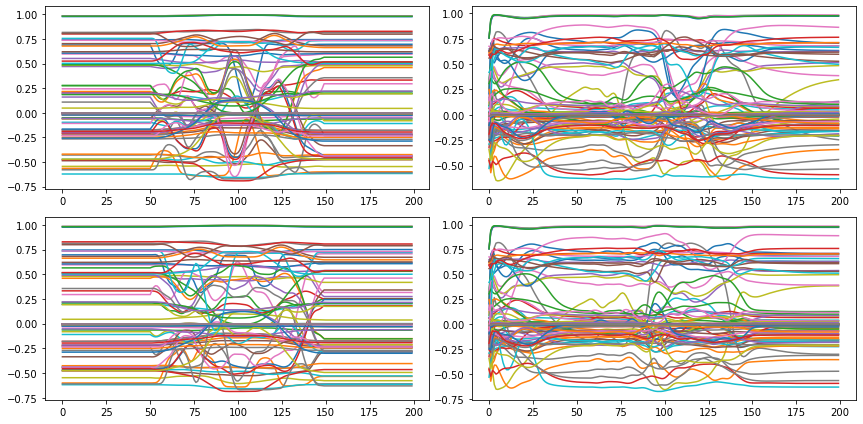

In [10]:
# Encode and decode sequences to check the model performance
decoded_seqs = autoencoder.predict(data)
# Plot the results
n = 2  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data[i])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(decoded_seqs[i])
plt.tight_layout()
plt.show()

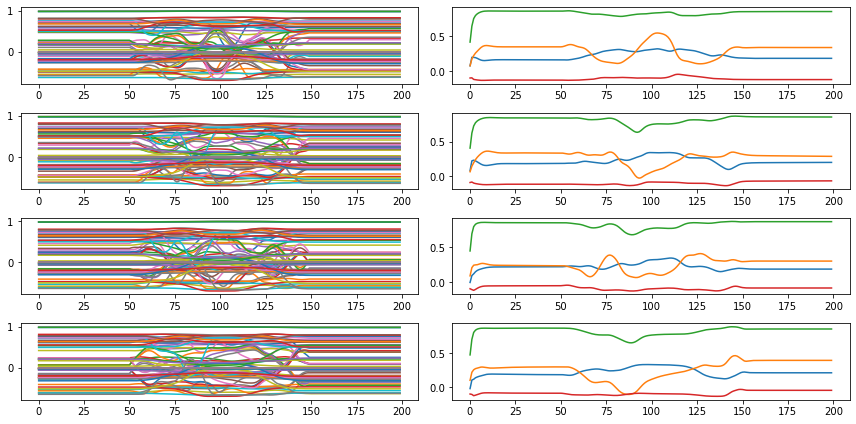

In [11]:
# Create an encoder model, that maps an input to its encoded representation
encoder = Model(inputs=input_seq, outputs=encoded)

# Test the encoder model
encoded_seqs = encoder.predict(data)

# Plot the results
n = 4  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data[i])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(encoded_seqs[i])
plt.tight_layout()
plt.show()

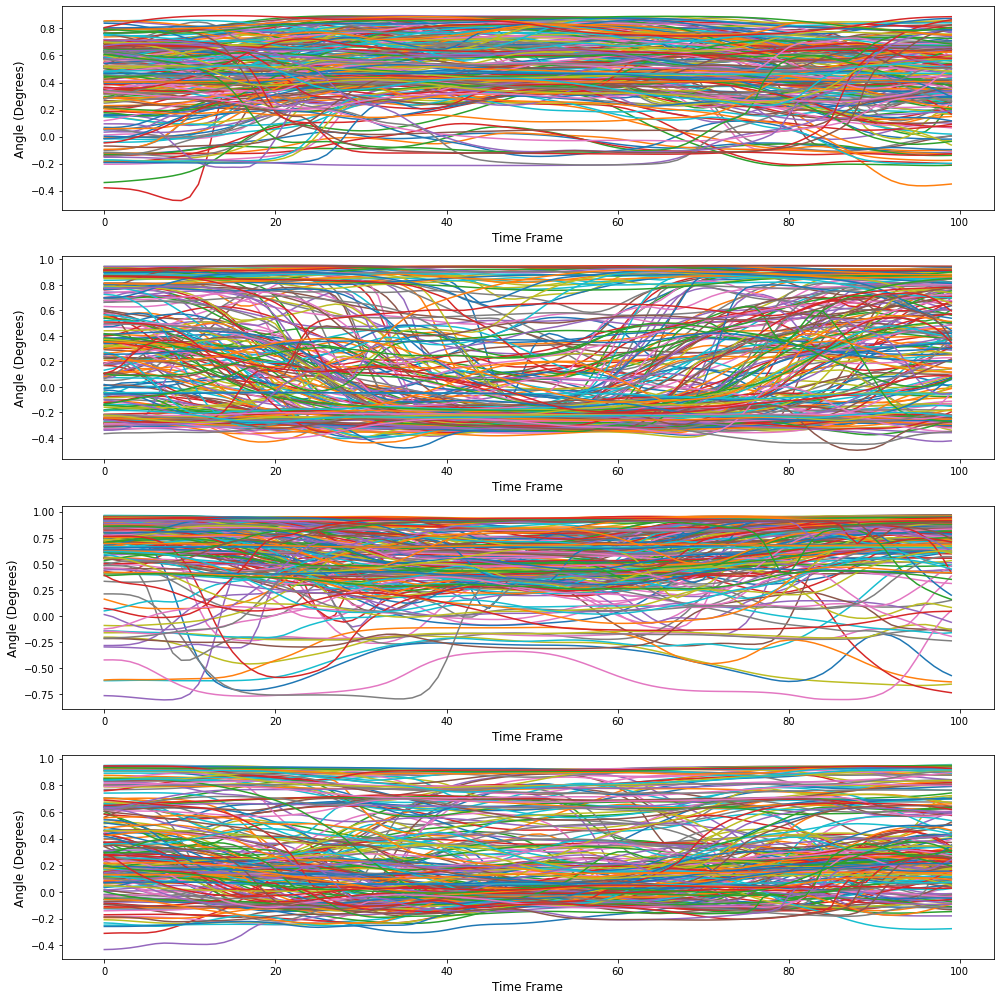

In [12]:
# Plot all encoded sequences without the first and last 50 time frames
plt.figure(figsize = (14,14))
for i in range(data.shape[0]):
    plt.subplot(4,1,1)
    plt.plot(encoded_seqs[i,50:-50,0])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,2)
    plt.plot(encoded_seqs[i,50:-50,1])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,3)
    plt.plot(encoded_seqs[i,50:-50,2])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
    plt.subplot(4,1,4)
    plt.plot(encoded_seqs[i,50:-50,3])
    plt.xlabel('Time Frame',fontsize=12)
    plt.ylabel('Angle (Degrees)',fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# Remove the added first and last 50 frames 
encoded_seqs = encoded_seqs[:,50:-50,:]

print(encoded_seqs.shape, 'encoded sequences shape')
# Reshape the encoded sequences, because savetxt saves two dimensional data
seqs = encoded_seqs.reshape(encoded_seqs.shape[0],encoded_seqs.shape[1]*encoded_seqs.shape[2])
print(seqs.shape, 'encoded sequences shape for saving')
# Save the data in the file 'Autoencoder_Output_Correct.csv'
np.savetxt('Autoencoder_Output_Correct.csv', seqs, fmt='%.5f',delimiter=',')

(204, 100, 4) encoded sequences shape
(204, 400) encoded sequences shape for saving


In [14]:
autoencoder.save("autoencoder")
encoder.save("encoder")

INFO:tensorflow:Assets written to: autoencoder\assets


INFO:tensorflow:Assets written to: autoencoder\assets


INFO:tensorflow:Assets written to: encoder\assets


INFO:tensorflow:Assets written to: encoder\assets


In [15]:
e = load_model("encoder")

In [16]:
a = encoder.predict(data)

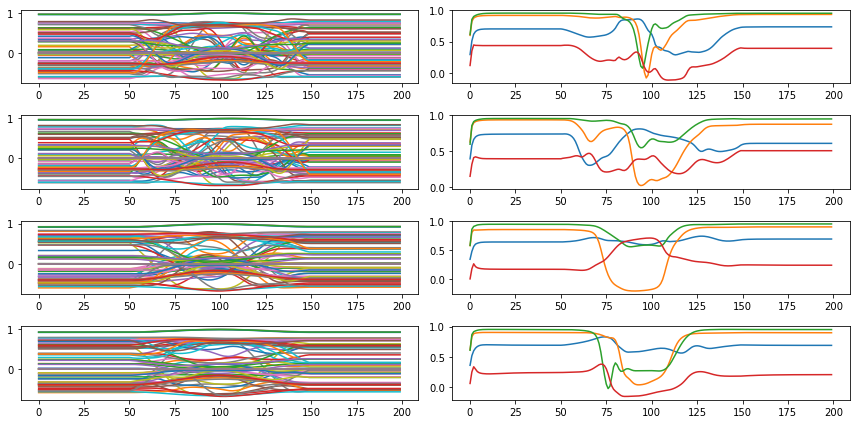

In [17]:
n = 4  # how many sequences we will display
plt.figure(figsize = (12,6))
for i in range(n):
    # display original sequences
    plt.subplot(n, 2, 2*i+1)
    plt.plot(data[i+10])
    
    # display reconstruction
    plt.subplot(n, 2, 2*i+2)
    plt.plot(a[i+10])
plt.tight_layout()
plt.show()